In [67]:
import pandas as pd 
import sklearn.preprocessing as skp
import matplotlib.pyplot as plt
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import concatenate
from sklearn.metrics import mean_squared_error

In [68]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    #input sequence
    for i in range(n_in,0,-1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)'%(j+1,i)) for j in range(n_vars)]
    #output sequence
    for i in range(0,n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    res = pd.concat(cols, axis = 1)
    res.columns = names
    if dropnan:
        res.dropna(inplace = True)
    return res

In [69]:
def Divide(data,feature_num,days = 20,steps = 3):
    train_hours = days*24
    train = data[:train_hours,:]
    test = data[train_hours:,:]
    train_data,train_label = train[:,:-1],train[:,-1]
    test_data,test_label = test[:,:-1],test[:,-1]
    train_data = train_data.reshape((train_data.shape[0],steps,feature_num))
    test_data = test_data.reshape((test_data.shape[0]),steps,feature_num)
    print("Data processing completed，data shape is{size}".format(size = train_data.shape))
    return train_data,train_label,test_data,test_label

Import data

In [70]:
df = pd.read_excel("AirQualityUCI.xlsx",parse_dates=[['Date', 'Time']])
df['Date_Time'] = pd.to_datetime(df.Date_Time , format = '%d/%m/%Y %H.%M.%S')
data = df.drop(['Date_Time'], axis=1)
data.index = df.Date_Time
Frame = pd.DataFrame(data,columns=['CO(GT)','PT08.S1(CO)','C6H6(GT)'])

In [71]:
for row in list(Frame):
    for index,row_d in df.iterrows():
        if(Frame[row][index] == -200):
            m=1
            while(Frame[row][index+m] == -200):
                m+=1
            Frame[row][index] = (Frame[row][index-1]+Frame[row][index+m])/2

Transfer it to data can be used in supervised problems

In [72]:
Terms_use = 3
Predict_terms = 1

values = Frame.values.astype('float32')
#Transfer
reframed = series_to_supervised(values, Terms_use, Predict_terms)

#We use var1,var2,var3 to predict var1(t) here,so we need to drop last 2 columns
reframed.drop(reframed.columns[[-1,-3]], axis=1, inplace=True)

#Because of tanh in LSTM cells we should normailze data between 0 and 1
scaler = skp.MinMaxScaler(feature_range=(0, 1))
scaled_frame = scaler.fit_transform(reframed)

print(reframed.shape)

(9354, 10)


D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


Transforming variables into a form suitable for LSTM cells input             
(Input_number,time steps used to predict,feature_number)

In [73]:
feature_num = 3
previous_steps_used = 3
days_pre = 300
X_train,Y_train,X_test,Y_test = Divide(scaled_frame,feature_num,days_pre,previous_steps_used)

Data processing completed，data shape is(7200, 3, 3)


### Network build 

In [74]:
LSTM_net = Sequential()
LSTM_net.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
LSTM_net.add(Dense(1,init = 'TruncatedNormal' ))
LSTM_net.compile(loss='mae', optimizer='adam')

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="TruncatedNormal")`
  This is separate from the ipykernel package so we can avoid doing imports until


In [75]:
history = LSTM_net.fit(X_train, Y_train, epochs=30, batch_size=72, validation_data=(X_test, Y_test), verbose=2, shuffle=False)

Train on 7200 samples, validate on 2154 samples
Epoch 1/30
 - 2s - loss: 0.1480 - val_loss: 0.0810
Epoch 2/30
 - 0s - loss: 0.0830 - val_loss: 0.0752
Epoch 3/30
 - 0s - loss: 0.0787 - val_loss: 0.0697
Epoch 4/30
 - 0s - loss: 0.0728 - val_loss: 0.0642
Epoch 5/30
 - 0s - loss: 0.0659 - val_loss: 0.0567
Epoch 6/30
 - 0s - loss: 0.0612 - val_loss: 0.0542
Epoch 7/30
 - 0s - loss: 0.0593 - val_loss: 0.0522
Epoch 8/30
 - 0s - loss: 0.0574 - val_loss: 0.0502
Epoch 9/30
 - 0s - loss: 0.0559 - val_loss: 0.0486
Epoch 10/30
 - 0s - loss: 0.0548 - val_loss: 0.0473
Epoch 11/30
 - 0s - loss: 0.0541 - val_loss: 0.0465
Epoch 12/30
 - 0s - loss: 0.0535 - val_loss: 0.0459
Epoch 13/30
 - 0s - loss: 0.0530 - val_loss: 0.0455
Epoch 14/30
 - 0s - loss: 0.0526 - val_loss: 0.0450
Epoch 15/30
 - 0s - loss: 0.0524 - val_loss: 0.0448
Epoch 16/30
 - 0s - loss: 0.0520 - val_loss: 0.0446
Epoch 17/30
 - 0s - loss: 0.0516 - val_loss: 0.0447
Epoch 18/30
 - 0s - loss: 0.0512 - val_loss: 0.0447
Epoch 19/30
 - 0s - loss:

Plot training loss 

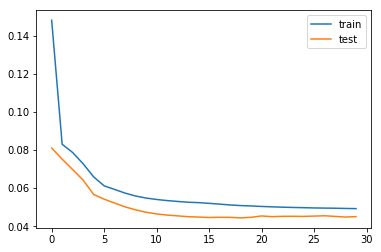

In [76]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [77]:
Prediction = LSTM_net.predict(X_test)
print(Prediction.shape)
print(Prediction)

(2154, 1)
[[0.35845888]
 [0.36083323]
 [0.36134946]
 ...
 [0.37062758]
 [0.38632986]
 [0.2636317 ]]


### Compare prediction and ground_truth

Data Reduction

In [78]:
X_test = X_test.reshape((X_test.shape[0],feature_num*previous_steps_used))
print(X_test.shape)

(2154, 9)


In [79]:
Reduction = concatenate((Prediction,X_test),axis=1)
Reduction = scaler.inverse_transform(Reduction)
Reduction = Reduction[:,0]

Reduction of Ground_Truth

In [80]:
Y_test = Y_test.reshape((len(Y_test),1))
Reduction_truth = concatenate((Y_test,X_test),axis = 1)
Reduction_truth = scaler.inverse_transform(Reduction_truth)
Ground_truth = Reduction_truth[:,0]

In [81]:
rmse = math.sqrt(mean_squared_error(Reduction, Ground_truth))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.751


In [82]:
print(Ground_truth)

[4.23317761 4.23317761 4.23317761 ... 4.29249538 3.11037692 3.6887252 ]


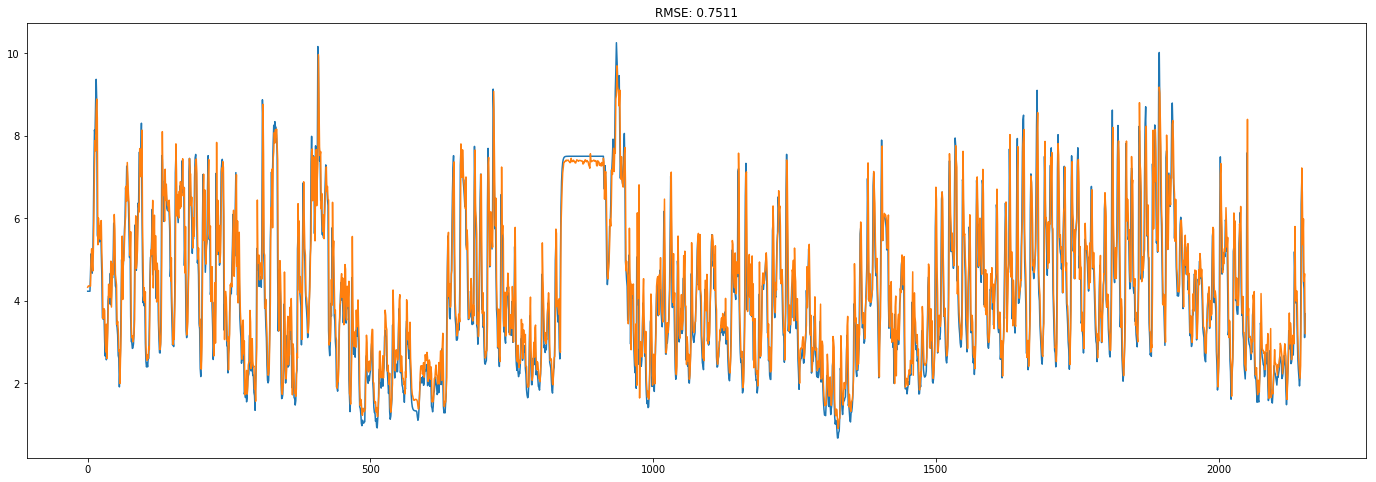

In [83]:
index = range(len(Ground_truth))
plt.figure(facecolor = 'white',figsize = (24,8))
plt.plot(index,Ground_truth,label = 'Ground_truth')
plt.plot(index,Reduction,label = 'Prediction')
plt.title('RMSE: %.4f'% rmse)
plt.show()